<a href="https://colab.research.google.com/github/BrindanYasodaran/UDL-oxford/blob/main/What_does_my_model_know%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can I model my own uncertainty❔
There are two kinds of uncertainties in life - external and internal, aleatoric and epistemic. Let's say we're in a game show where the host shows us a dog and we need to guess its breed - because of the game's __nature__ we don't know which dog we'll get in advance, while due to __our own__ lack of knowledge - having not seen enough dogs in life, like most people - we won't always know the dog's breed even after we've seen it.

While last time we saw how to model aleatoric uncertainties, today we'll attempt better understanding epistemic ones.

---
## 0. How do I know how much I know? 🤔
In the previous example, given knowledge about dogs we've seen we want to predict a new dog's breed after they're presented to us. Formally, there's some distribution over the possible breeds given how a dog looks. If we've seen dogs $X$ (representing how they look) of breeds $y$ (categorically representing the dogs' breed) then given a new dog $x^*$ we want to predict $y^*$ - or in other words, find $p(y^*|x^*,X,y)$. This probability represents our _beliefs and uncertainties_ about the world.

❔  
__Q0:__  
a) in this case, what kind of distribution is this?  
b) If we were expert dog trainers who knew how to spot a breed very well, what would this distribution tend to given infinite data?

__A:__ _answer!_
a) categorical distribution

b) one-hot categorical distribution

In practice, we have different models of reality we're using to make decisions - most Labradors are yellow, Poodles having wiry hair, etc. If we see a dog with a mix of these features we're weighing how important each one is. In machine learning, these different possibilities are represented by different possible models that fit our known view of reality. We usually define them using parameters denoted by $w$.

This is best illustrated with an example. Let's say we're fitting a model to some data, where for ease of visualisation we'll deal with regression. If there are many ways a model can fit the data we'd expect different models to behave differently when they're unsure, AKA far from what's known. Let's test this in practice:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Generating artificial 1D data
torch.manual_seed(42)
sigma = .2
x_data = torch.linspace(-3, 3, 100).unsqueeze(1)
y_data = torch.sin(x_data) + sigma*torch.randn_like(x_data)

In [5]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    return self.fc2(x)

In [6]:
def train_model(model, x_data, y_data, lr=0.01, epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_data)
        loss = F.mse_loss(y_pred, y_data)
        loss.backward()
        optimizer.step()
        if epoch % 200 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    return model

In [7]:
# Create and train multiple models to form an ensemble
num_models = 5
models = []
for i in range(num_models):
    # Set different random seeds for each model
    torch.manual_seed(i * 100)
    model = MLP(input_dim=1, hidden_dim=20, output_dim=1)
    models.append(train_model(model, x_data, y_data))
    print(f"Model {i+1} trained")

Epoch 0, Loss: 0.5658
Epoch 200, Loss: 0.0415
Epoch 400, Loss: 0.0376
Epoch 600, Loss: 0.0357
Epoch 800, Loss: 0.0340
Model 1 trained
Epoch 0, Loss: 1.2587
Epoch 200, Loss: 0.0446
Epoch 400, Loss: 0.0386
Epoch 600, Loss: 0.0364
Epoch 800, Loss: 0.0350
Model 2 trained
Epoch 0, Loss: 0.4076
Epoch 200, Loss: 0.0409
Epoch 400, Loss: 0.0364
Epoch 600, Loss: 0.0344
Epoch 800, Loss: 0.0327
Model 3 trained
Epoch 0, Loss: 0.8463
Epoch 200, Loss: 0.0443
Epoch 400, Loss: 0.0384
Epoch 600, Loss: 0.0358
Epoch 800, Loss: 0.0341
Model 4 trained
Epoch 0, Loss: 1.0875
Epoch 200, Loss: 0.0448
Epoch 400, Loss: 0.0385
Epoch 600, Loss: 0.0365
Epoch 800, Loss: 0.0353
Model 5 trained


In [8]:
# Generate predictions for visualization
x_test = torch.linspace(-5, 5, 200).unsqueeze(1)  # Extend beyond training range
predictions = []

with torch.no_grad():
    for model in models:
        model.eval()
        predictions.append(model(x_test))

predictions = torch.cat(predictions, dim=1)  # Shape: [200, num_models]
mean_predictions = predictions.mean(dim=1)
std_predictions = predictions.std(dim=1)

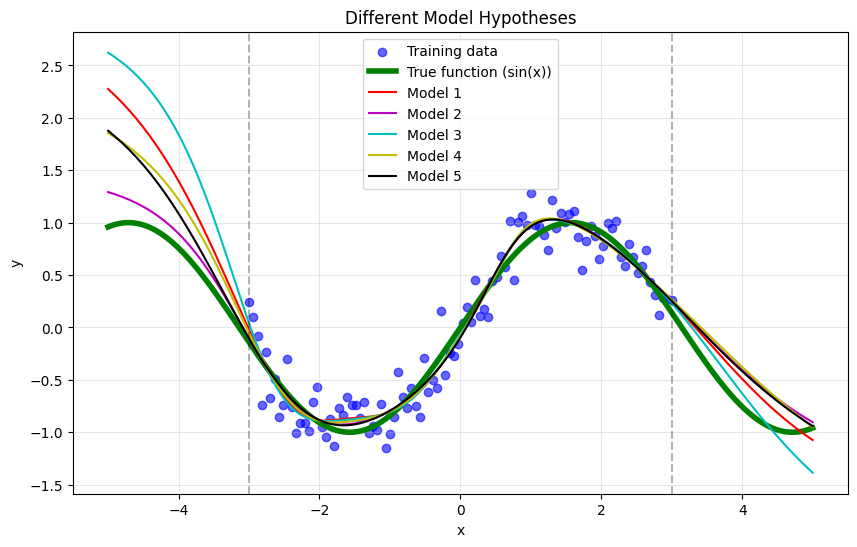

In [9]:
x_true = np.linspace(-5, 5, 1000)
y_true = np.sin(x_true)

# Plot individual model predictions to visualize different hypotheses
plt.figure(figsize=(10, 6))
plt.scatter(x_data.numpy(), y_data.numpy(), color='blue', alpha=0.6, label='Training data')
plt.plot(x_true, y_true, 'g-', label='True function (sin(x))', linewidth=4)

colors = ['r', 'm', 'c', 'y', 'k']
for i, pred in enumerate(predictions.transpose(0, 1)):
    plt.plot(x_test.numpy(), pred.numpy(), f'{colors[i]}-', label=f'Model {i+1}')

plt.axvline(x=-3, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=3, color='k', linestyle='--', alpha=0.3)

plt.title('Different Model Hypotheses')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

❔  
__Q1:__ there are different hypotheses - or in our case, models - that fit reality. Formally, different parameters $w$ can fit the data $X,y$. What probability density function describes this uncertainty in the weights? To be clear, the question isn't if it's Gaussian/Uniform/etc. but what's the functional form, e.g. $p(a,b|c)$.

__A:__ _answer!_ (ideally try having a demonstrator check your solution before continuing)
- The posterior, i.e. p(w | X, y)

Let's compare this with what we usually do - maximum likelihood estimation (MLE). In this case we find a single set of weights - $\tilde{w}$ - and generate predictions using them, so $p(y^*|x^*,X,y)=p(y^*|x^*,\tilde{w})$. For example, when fitting a Gaussian $\tilde{w}$ may be its mean and variance.

❔  
__Q2:__ In an ideal Bayesian framework we would _marginalise_ over all possible hypotheses (in practice - weights) to get our solution. Write an expression that shows how using Q1's distribution one can find $p(y^*|x^*,X,y)$.

__A:__ _answer!_

$ p(y^* \mid x^*, X, y) = \int p(y^* \mid x^*, w)\, p(w \mid X, y)\, dw $


__Q3:__ what uncertainty did we just model?

__A:__ _answer!_
- epistemic

---
The questions in this section are optional but highly advised for your understanding. It's recommendded to do at least one, ideally that which is hardest for you.

Let's illustrate this uncertainty with an explicit example.

❔  
__Q4:__ Let's say $w$ represents a (1D) Gaussian's mean, and we find that $p(w|X,y)=\mathcal{N}(1,1)$. Let's assume that $p(y^*|x^*,w)=\mathcal{N}(wx^*,1)$. What would be $p(y^*|x^*,X,y)$? Recommend finding this both analytically and numerically!

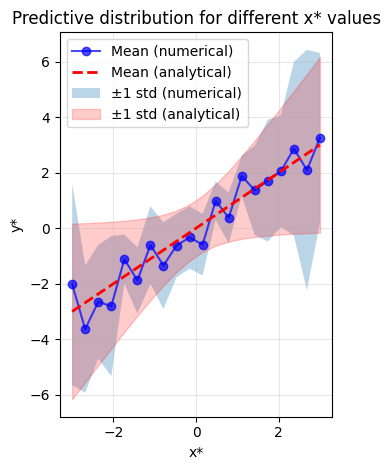

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Numerical computation using Monte Carlo sampling
def compute_predictive_numerical(x_star, n_samples=1):
    # Sample w from posterior p(w|X,y) = N(1, 1)
    w_samples = np.random.normal(loc=1, scale=1, size=n_samples)

    y_star_samples = np.random.normal(loc=w_samples * x_star, scale=1)

    # The samples of y* approximate p(y*|x*, X, y)
    # Compute empirical mean and variance
    mean_numerical = np.mean(y_star_samples)
    var_numerical = np.var(y_star_samples)
    std_numerical = np.sqrt(var_numerical)

    return mean_numerical, var_numerical, std_numerical, y_star_samples

# Test for multiple x* values
plt.subplot(1, 2, 2)
x_star_values = np.linspace(-3, 3, 20)
means_num = []
stds_num = []
means_analytical = []
stds_analytical = []

for x_s in x_star_values:
    m_num, v_num, s_num, _ = compute_predictive_numerical(x_s, n_samples=10)
    means_num.append(m_num)
    stds_num.append(s_num)

    # Analytical
    means_analytical.append(x_s)
    stds_analytical.append(np.sqrt(x_s**2 + 1))

means_num = np.array(means_num)
stds_num = np.array(stds_num)
means_analytical = np.array(means_analytical)
stds_analytical = np.array(stds_analytical)

plt.plot(x_star_values, means_num, 'bo-', label='Mean (numerical)', alpha=0.7)
plt.plot(x_star_values, means_analytical, 'r--', label='Mean (analytical)', linewidth=2)
plt.fill_between(x_star_values, means_num - stds_num, means_num + stds_num,
                 alpha=0.3, label='1 std (numerical)')
plt.fill_between(x_star_values, means_analytical - stds_analytical,
                 means_analytical + stds_analytical,
                 alpha=0.2, color='red', label='1 std (analytical)')
plt.xlabel('x*')
plt.ylabel('y*')
plt.title('Predictive distribution for different x* values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__A:__ _answer!_

Write the likelihood using an explicit noise term:

$y^* = w x^* + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 1)$.

Since $w \sim \mathcal{N}(1, 1)$, multiplying by $x^*$ gives

$w x^* \sim \mathcal{N}(x^*, x^{*2})$.

Now $w x^*$ and $\varepsilon$ are independent Gaussian random variables, so their sum is also Gaussian:

$w x^* + \varepsilon \sim \mathcal{N}\big(x^* + 0,\; x^{*2} + 1\big)$.

But $y^* = w x^* + \varepsilon$, so

$y^* \mid x^*, X, y \sim \mathcal{N}\big(x^*,\; x^{*2} + 1\big)$.

❔  
__Q5:__ MLE can be interpreted as approximating full Bayesian marginalisation. How so? When will this approximation be accurate?


__A:__ _answer!_
- The weights found by MLE can be thought of as posterior mode under a uniform prior
- This is because, when using a uniform prior, maximising the posterior is the same as maximising the likelihood
- Instead of averaging over all plausible weights w we pretend the true
w is exactly the MLE
-  So the approximation will be accurate when the true posterior is sharp around its mode

❔  
__Q6:__ ensembling - training several models and taking their mean prediction - can also be seen as an approximation of this. How so?


__A:__ _answer!_
- Rather than integrating over the entire set of weights to compute the predictive
- We instead sample weights which have high probability according to the posterior
- These weight configurations with high probability are exactly the weight configurations of the different models of the ensemble
- So we can think of ensembling as a monte carlo approximation of the true predictive distribution

---
**Spoilers, continue only after previous part**
## 1. How can I use what I know? 🔧🔨
Scroll down if you've finished the previous section!
<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>
By now you likely understood that we're talking about: epistemic uncertainty!   

However, as we know, there are two kinds of uncertainties - aleatoric and epistemic. We know how to model aleatoric uncertainties - how can I know if my model is unsure because it just needs more data or because of the problem's inherent uncertainty?

The natural solution is, as we did in the aleatoric case, to model our epistemic uncertainty explicitly.

Remember, epistemic uncertainty is uncertainty inherent in the model. To get a grasp of it let's start with a simple case - estimating a linear regression model's uncertainty.

What is "a model's uncertainty"? It helps thinking of each model as a hypothesis. Several hypotheses could explain (fit) the data, with each hypothesis being defined using some weights.

When placing a prior over our hypotheses - believing some are more likely than others before seeing the data - maximum likelihood estimation becomes _maximum a posteriori estimation_ (MAP). You should be familiar with this from previous practicals but if not, review the MAP derivation for linear regression in the Goodfelloow et al. deep learning book, section 5.6.1, or section 3.3 in the Chris Bishop PRML book, or section 4.5 in Kevin Murphy's "Probabilistic Machine Learning: An Introduction".

❔  
__Q7:__ assuming a linear regression model with homoscedastic noise and an isotropic Gaussian prior with zero mean on the weights, what's their posterior mean and covariance? What's the negative log of the posterior distribution (the MAP equivalent of MLE's negative log likelihood)? Note that although a priori the weights are decoupled their posterior will likely have a non-diagonal covariance (make sure you understand why!).

- since we have linear regression model with homoscedastic noise, likelihood term is $p(y \mid X, w) = \mathcal{N}(y \mid Xw, \sigma^2 I)$
- since prior is isotropic Gaussian with zero mean, it can be written as $w \sim \mathcal{N}(0, \alpha^{-1} I)$
- we showed in lectures how to compute the posterior mean and covariance in closed form
- by conjugacy, posterior is gaussian
- we expand out the pdf's of the likelihood and prior, and compute the product, likelihood*prior
- we can ignore constant terms (i.e. terms not depending on w)
-

__A:__ _answer!_

__A:__

**Setup:**
- Linear regression: $y = Xw + \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, \sigma^2 I)$ (homoscedastic noise)
- Prior: $p(w) = \mathcal{N}(0, \tau^2 I)$ (isotropic Gaussian with zero mean)
- Likelihood: $p(y|X,w) = \mathcal{N}(Xw, \sigma^2 I)$

**Posterior mean and covariance:**

The posterior $p(w|X,y)$ is Gaussian with:

$$\mu = (X^T X + \frac{\sigma^2}{\tau^2}I)^{-1} X^T y$$

$$\Sigma = \sigma^2(X^T X + \frac{\sigma^2}{\tau^2}I)^{-1}$$

We did a very similar derivation in lectures.

**Negative log posterior (MAP objective):**

$$-\log p(w|X,y) = -\log p(y|X,w) - \log p(w) + \text{const}$$

$$= \frac{1}{2\sigma^2}||y - Xw||^2 + \frac{1}{2\tau^2}||w||^2 + \text{const}$$

This is equivalent to **ridge regression** with regularization parameter $\lambda = \sigma^2/\tau^2$:

$$\text{MAP objective: } ||y - Xw||^2 + \lambda||w||^2$$

**Why is the posterior covariance non-diagonal?**

Even though the prior covariance is diagonal (weights are independent a priori), the posterior covariance is generally not diagonal because:
- The matrix $X^T X$ captures correlations between features in the data
- When features are correlated, our uncertainty about one weight becomes correlated with our uncertainty about other weights

❔  
__Q8:__ that's a bit messy! Often for simplicity (and as we'll see later, for optimisation efficiency) we assume each weight has its own, decoupled variance, effectively assuming a diagonal covariance matrix. This is often known as a _mean field_ approximation. In this setting what's the **form** of the posterior over the weights, $p(w|X,y)$? Thus, what's the resulting predictive distribution $p(y^*|x^*,X,y)$? "Form" means there's no need to find the analytical values but if we knew them then what the resulting expressions will look like. This can be a bit complicated, so it's recommended to do it step by step:  
1. What form will the final weights' posterior and predictive distributions have?
2. Given this, what are the predictive's sufficient statistics? "Sufficient statistics" here means the parameters needed to fully define it, e.g. a Poisson distribution's single sufficient statistic is its rate parameter $\lambda$.
3. These can be found by completing the square - as we've seen in the lectures - but that can be a bit complicated. Instead, it's recommended to find the sufficient statistics by using expectations/variances, and if need be conditional expectations/variances, relative to the distribution of $y^*|x^*,w$. Make sure what you're computing corresponds to the actual predictive distribution! _Note - regardless of whether you're completing the square or using these expectations/variances, there's no need to compute any integrals._
4. After computing these expectations the sufficient statistics can be straightforwardly identified.

__A:__ _answer!_


__A:__

Following the step-by-step approach:

1. What form will the distributions have?

With a mean field approximation (diagonal covariance), the posterior over weights is:
$$p(w|X,y) = \prod_i \mathcal{N}(w_i | \mu_i, \sigma_i^2)$$

Since $y^*$ is a linear combination of Gaussian random variables ($w^\top x^*$) plus independent Gaussian noise ($\varepsilon$), the final predictive distribution $p(y^* \mid x^*, X, y)$ must also be Gaussian.

2. Finding the sufficient statistics using expectations:

We want to find $$\mathbb{E}[y^* \mid x^*, X, y] $$

By law of total expectation, we know:
$$\mathbb{E}[y^* \mid x^*, X, y] = \mathbb{E}_w\big[\mathbb{E}[y^* \mid x^*, w]\big]$$

So, we have,

$$\mathbb{E}_w\big[\mathbb{E}[y^* \mid x^*, w]\big] = \mathbb{E}_w[w^\top x^*] = (\mathbb{E}_w[w])^\top x^* = m^\top x^*$$

where,  $w \sim \mathcal{N}(m, S)$, and so $\mathbb{E}[w] = m$.

We also want to find, $$\operatorname{Var}(y^* \mid x^*, X, y)$$

we know by law of total variance that

$$\operatorname{Var}(y^* \mid x^*, X, y) = \mathbb{E}_w\big[\operatorname{Var}(y^* \mid x^*, w)\big] + \operatorname{Var}_w\big(\mathbb{E}[y^* \mid x^*, w]\big)$$

For the first term, we know $\operatorname{Var}(y^* \mid x^*, w) = \sigma^2$

For the second term:
$$\operatorname{Var}_w(\mathbb{E}[y^* \mid x^*, w]) = \operatorname{Var}_w(w^\top x^*)$$

If $w \sim \mathcal{N}(m, S)$, the variance of a linear combination $w^\top x^*$ is given by the quadratic form:$$\operatorname{Var}_w(w^\top x^*) = x^{* \top} S x^*$$

So, overall,  $$\operatorname{Var}(y^* \mid x^*, X, y) = \sigma^2 +  x^{* \top} S x^*$$

The predictive variance has two component corresponding to aleoteric and epistemic uncertainty

---
# 2. Baby's First Bayesian Net 👶

Ideally we want to use powerful models - like deep neural networks - instead of simple linear regressions. However, modelling a complicated model's uncertainty is no easy task! Even assuming a mean field approximation, each weight is duplicated as it has both a mean and a variance, and optimising both at once can be challenging. A simple step towards that is assuming only the last layer's weights have some uncertainty, so most of the model is unchanged.

Let's play with this using the regression model from the last practical. Here we'll assume homoscedastic noise, so the aleatoric uncertainty won't be input dependent.

##### Here's our boilerplate

In [1]:
import numpy as np

DATA_STD = 0.2

def gt_func(x):
  return np.cos(x)+x**2/5

def gen_data(n_points, sigma=DATA_STD):
  x = np.linspace(-4, 4, n_points)
  y = gt_func(x)+sigma*np.random.randn(n_points)

  x = torch.tensor(x).float().unsqueeze(-1)
  y = torch.tensor(y).float()

  return x, y

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def train_model(x, y, model, loss_fn, lr: float=1e-3, n_epochs: int=300, bs: int=25):
  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  dloader = DataLoader(list(zip(x, y)), shuffle=True, batch_size=bs)

  for epoch in range(n_epochs):
    train_loss = 0
    for batch_x, batch_y in dloader:
      optimiser.zero_grad()

      output = model(batch_x)
      loss = loss_fn(output, batch_y.unsqueeze(-1))

      loss.backward()
      optimiser.step()

      train_loss += loss.item() * len(batch_x)

    train_loss /= len(x)

    if epoch % 20  == 0:
      print(f'Epoch: {epoch+1}/{n_epochs}, loss: {train_loss:.4f}')

  return model

In [3]:
import matplotlib.pyplot as plt

def plot_preds(model, x, y):
  preds = model(x).detach().numpy()

  x = x.numpy()
  plt.scatter(x, y, label='data')
  if preds.shape[1] == 1:
    plt.scatter(x, preds, label='predictions', c='r')
  else:
    a = preds[:, 0]
    b = np.exp(.5 * preds[:, 1])
    plt.errorbar(x, a, yerr=b, label='predictions', marker='o',
                 linestyle='None', c='r')

  x = np.linspace(-4, 4)
  plt.plot(x, gt_func(x), label='ground truth')

  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

##### And here's our basic, standard MLP

In [4]:
class MLP(nn.Module):
  def __init__(self, n_inputs: int, n_outputs: int):
    super(MLP, self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_outputs)
    )

  def forward(self, x):
    return self.layers(x)

In [5]:
train_x, train_y = gen_data(25)

In [6]:
model = MLP(1, 1)
mse_loss = nn.MSELoss()
model = train_model(train_x, train_y, model, loss_fn=mse_loss)

Epoch: 1/300, loss: 1.1741
Epoch: 21/300, loss: 0.2067
Epoch: 41/300, loss: 0.0843
Epoch: 61/300, loss: 0.0229
Epoch: 81/300, loss: 0.0172
Epoch: 101/300, loss: 0.0144
Epoch: 121/300, loss: 0.0128
Epoch: 141/300, loss: 0.0113
Epoch: 161/300, loss: 0.0098
Epoch: 181/300, loss: 0.0088
Epoch: 201/300, loss: 0.0075
Epoch: 221/300, loss: 0.0074
Epoch: 241/300, loss: 0.0069
Epoch: 261/300, loss: 0.0059
Epoch: 281/300, loss: 0.0055


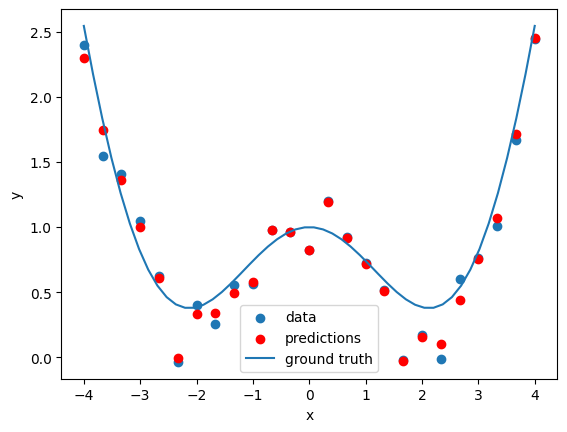

In [7]:
plot_preds(model, train_x, train_y)

In [8]:
# print test loss
test_x, test_y = gen_data(1000)
model.eval()
with torch.no_grad():
    test_pred = model(test_x)
    test_loss = mse_loss(test_pred, test_y.unsqueeze(-1))
    print(f'Test loss: {test_loss.item():.4f}')

Test loss: 0.0699


Here we're training a single model that gives us a single output. We want to train a (simple) distribution over weights, such that a) we see how confident our model is in itself and b) we can have different models (hypotheses).

❔  
__Q9:__ if only our last layer weights have some uncertainty while all the previous ones are "regular layers", what's the negative log of our predictive distribution? Although it's technically possible to analytically solve for the posterior weights' mean and variances here, assume for simplicity we only know the posterior's form and not the analytical solution, so we can get the means and variances through optimisation like the "regular" weights. This is a) simpler and b) what happens in even slightly more complicated models.   
It's highly recommended that you check your answer by plugging in some extremes, e.g. what happens when your model has no epistemic uncertainty?

__A:__ _answer!_

Assume we know the posterior (last layer) weight's mean and variance (We get these through optimisation)
- $\mu_w$ = vector of weight means
- $\Sigma_w$ = diagonal covariance matrix

Let the output of the penultimate layer be $h = f(x; \theta)$ , where $\theta$ are regular weights

We do bayesian linear regression on input $h$. In particular
- $y^* = w^T h + \varepsilon$ where $w \sim p(w|X,y)$ and $\varepsilon \sim \mathcal{N}(0, \sigma^2)$

And so we can use the answer from the previous part to know that 1) the predictive distribution is normal and 2) the the mean and variance of the predictive distribution is as follows:
$$p(y^*|x^*, X, y) = \mathcal{N}(\mu_w^T h, \sigma^2 + h^T \Sigma_w h)$$

The negative log predictive distribution (loss) is hence:

$$-\log p(y^*|x^*, X, y) = \frac{1}{2}\log(2\pi(\sigma^2+ h^T \Sigma_w h)) + \frac{(y^* - \mu_w^T h)^2}{2(\sigma^2 + h^T \Sigma_w h)} + \text{const}$$

For optimization, we can drop constants:

$$\frac{1}{2}\log(\sigma^2 + h^T \Sigma_w h) + \frac{(y - \mu_w^T h)^2}{2(\sigma^2 + h^T \Sigma_w h)}$$

If our model has no epistemic uncertainty, i.e. $\Sigma_w  = 0$ then we end up with standard negative log likelihood loss on w (i.e. MSE)

🍓 **Food for thought** - when doing MLE or MAP we optimise our negative log likelihood or posterior, $p(y|X,w)$ and $p(x|X,y)$ respectively. Here we're seemingly interested in, and trying to optimise directly, an expression that does not include the weights at all, the predictive distribution $p(y^*|x^*,X,y)$ - how come?

- When doing bayesian linear regression, it is possible to instead optimise the posterior directly, then use this posterior to compute the predictive at inference time
- But since we have a closed form expression of the predictive (in terms of the mean and variance of the posterior) in this simple linear regression example, we can just optimise the predictive directly

❔  
__Q10:__ now let's train such a model. Fill in the missing code snippets **assuming we have 64 features in our final layer**. How does it perform relative to the regular model? Note that here we're for simplicity assuming the aleatoric uncertainty is given. You can define a new MLP class for convenience if you'd like, although the existing one is sufficient. If your model doesn't converge make sure you're calculating the loss properly, e.g. everything has the correct dimensions. You should essentially implement the loss you defined in the previous question verbatim, taking careful note of which parts of it should be learnt.

In [34]:
# Bayesian MLP with separate weight posterior parameters
class BayesianMLP(nn.Module):
  def __init__(self, n_inputs: int, n_features: int):
    super(BayesianMLP, self).__init__()

    # Deterministic layers (feature extractor)
    self.feature_extractor = nn.Sequential(
        nn.Linear(n_inputs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_features)
    )

    # Bayesian last layer parameters (learned, but fixed per input)
    # These represent the posterior p(w|X,y) = N(mu_w, diag(sigma_w^2))

    self.mu_w = nn.Parameter(torch.randn(n_features) * 0.01)  # Mean of weight posterior
    self.log_var_w = nn.Parameter(torch.ones(n_features) * (-5))  # Log variance (start very small)


  def forward(self, x):
    # Extract features h (this varies with input)
    h = self.feature_extractor(x)
    return h

  def get_predictive_params(self, h, data_std):
    """
    Compute predictive distribution parameters given features h
    Returns: (predictive_mean, predictive_variance)
    """
    # Predictive mean: mu_w^T h
    pred_mean = torch.sum(self.mu_w * h, dim=1, keepdim=True)

    # Epistemic variance: h^T Sigma_w h = sum(h_i^2 * sigma_i^2)
    var_w = torch.exp(self.log_var_w)
    epistemic_var = torch.sum(h**2 * var_w, dim=1, keepdim=True)

    # Total predictive variance: aleatoric + epistemic
    pred_var = data_std**2 + epistemic_var

    return pred_mean, pred_var


In [35]:
bayesian_model = BayesianMLP(n_inputs=1, n_features=64)

In [36]:
def predictive_loss_fn(model_outputs, y, data_std=DATA_STD, model=bayesian_model):
  h = model_outputs
  pred_mean, pred_var = model.get_predictive_params(h, data_std)

  nll = 0.5 * torch.log(pred_var) + (y.unsqueeze(-1) - pred_mean)**2 / (2 * pred_var)

  return nll.mean()

In [37]:
model = MLP(1, 64) # fill me!
model = train_model(train_x, train_y, model, loss_fn=predictive_loss_fn)

bayesian_model = train_model(train_x, train_y, bayesian_model, loss_fn=predictive_loss_fn)


Epoch: 1/300, loss: 11.2940
Epoch: 21/300, loss: 0.9851
Epoch: 41/300, loss: 0.4505
Epoch: 61/300, loss: 0.2336
Epoch: 81/300, loss: 0.1125
Epoch: 101/300, loss: 0.1019
Epoch: 121/300, loss: 0.1001
Epoch: 141/300, loss: 0.0995
Epoch: 161/300, loss: 0.0992
Epoch: 181/300, loss: 0.0990
Epoch: 201/300, loss: 0.0988
Epoch: 221/300, loss: 0.0987
Epoch: 241/300, loss: 0.0986
Epoch: 261/300, loss: 0.0986
Epoch: 281/300, loss: 0.0985
Epoch: 1/300, loss: 11.5184
Epoch: 21/300, loss: 0.8917
Epoch: 41/300, loss: 0.3936
Epoch: 61/300, loss: 0.1527
Epoch: 81/300, loss: 0.0641
Epoch: 101/300, loss: 0.0616
Epoch: 121/300, loss: 0.0610
Epoch: 141/300, loss: 0.0609
Epoch: 161/300, loss: 0.0609
Epoch: 181/300, loss: 0.0609
Epoch: 201/300, loss: 0.0609
Epoch: 221/300, loss: 0.0609
Epoch: 241/300, loss: 0.0609
Epoch: 261/300, loss: 0.0609
Epoch: 281/300, loss: 0.0609


In [38]:
def get_mean_preds(model_outputs, model=None):
  h = model_outputs
  return torch.sum(model.mu_w * h, dim=1, keepdim=True)

In [39]:
bayesian_model.eval()
with torch.no_grad():
    test_pred = bayesian_model(test_x)
    test_pred = get_mean_preds(test_pred, model=bayesian_model)
    test_loss = mse_loss(test_pred, test_y.unsqueeze(-1))
    print(f'Test loss: {test_loss.item():.4f}')

Test loss: 0.3032


❔  
__Q11:__ let's also visualise our outputs. As we have the predictive distribution in closed form we can plot the output distribution directly. Please plot not just the epistemic but the **predictive uncertainty**.

In [40]:
def plot_epistemic_preds(model, x, y, data_std=DATA_STD):
    # Forward pass
    model_outs = model(x).detach()

    h = model_outs
    pred_mean, pred_var = model.get_predictive_params(h, data_std)

    mean_preds = pred_mean.detach().cpu().numpy().flatten()
    std_pred = torch.sqrt(pred_var).detach().cpu().numpy().flatten()

    # Convert x and y to numpy
    x_np = x.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()

    # Plot data
    plt.scatter(x_np, y_np, label='data')

    # Plot mean and uncertainty bands
    plt.plot(x_np, mean_preds, label='mean', c='r')

    plt.plot(x_np, mean_preds + std_pred, label='mean$\pm$std', c='r', linestyle='--')
    plt.plot(x_np, mean_preds - std_pred, c='r', linestyle='--')

    plt.plot(x_np, mean_preds + 2 * std_pred, label='mean$\pm$2std', c='r', linestyle='-.')
    plt.plot(x_np, mean_preds - 2 * std_pred, c='r', linestyle='-.')

    # Ground truth curve
    x_gt = np.linspace(-4, 4)
    plt.plot(x_gt, gt_func(x_gt), label='ground truth')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-256228031.py:21: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_np, mean_preds + std_pred, label='mean$\pm$std', c='r', linestyle='--')
/tmp/ipython-input-256228031.py:24: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_np, mean_preds + 2 * std_pred, label='mean$\pm$2std', c='r', linestyle='-.')


In [42]:
def plot_epistemic_preds(model, x, y, data_std=DATA_STD):
    # Forward pass
    model_outs = model(x).detach()

    h = model_outs
    pred_mean, pred_var = model.get_predictive_params(h, data_std)

    mean_preds = pred_mean.detach().cpu().numpy().flatten()
    std_pred = torch.sqrt(pred_var).detach().cpu().numpy().flatten()

    # Convert x and y to numpy
    x_np = x.detach().cpu().numpy().flatten()
    y_np = y.detach().cpu().numpy().flatten()

    # Sort by x values for proper line plotting
    sort_idx = np.argsort(x_np)
    x_sorted = x_np[sort_idx]
    mean_sorted = mean_preds[sort_idx]
    std_sorted = std_pred[sort_idx]

    # Plot data (scatter doesn't need sorting)
    plt.scatter(x_np, y_np, label='data')

    # Plot mean and uncertainty bands (using sorted values)
    plt.plot(x_sorted, mean_sorted, label='mean', c='r')

    plt.plot(x_sorted, mean_sorted + std_sorted, label='mean$\pm$std', c='r', linestyle='--')
    plt.plot(x_sorted, mean_sorted - std_sorted, c='r', linestyle='--')

    plt.plot(x_sorted, mean_sorted + 2 * std_sorted, label='mean$\pm$2std', c='r', linestyle='-.')
    plt.plot(x_sorted, mean_sorted - 2 * std_sorted, c='r', linestyle='-.')

    # Ground truth curve
    x_gt = np.linspace(-4, 4)
    plt.plot(x_gt, gt_func(x_gt), label='ground truth')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()


<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3641822771.py:27: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_sorted, mean_sorted + std_sorted, label='mean$\pm$std', c='r', linestyle='--')
/tmp/ipython-input-3641822771.py:30: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_sorted, mean_sorted + 2 * std_sorted, label='mean$\pm$2std', c='r', linestyle='-.')


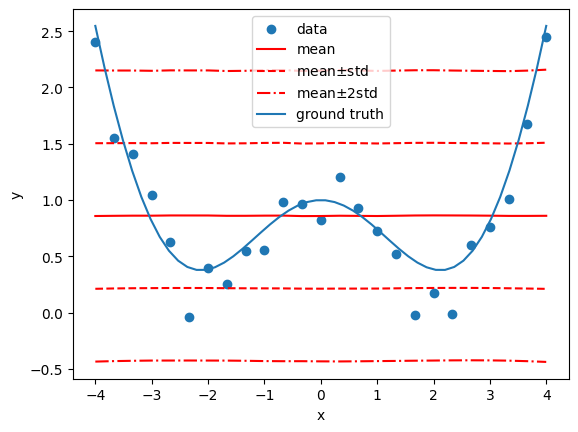

In [43]:
plot_epistemic_preds(bayesian_model, train_x, train_y)

❔  
__Q12:__ although we managed to get a model that's aware of its own uncertainty, the MSE test loss is not always better. What are some possible reasons why?

__A:__ _answer!_

❔  
__Q13:__ are we in practice modelling _only_ our epistemic uncertainty? What should we do if we wanted to take into account _both_ our aleatoric and epistemic uncertainties?

__A:__ _answer!_

---

# 3. Fin
And that's a wrap for the practicals :) We hope you enjoyed the course and got some new perspectives. It's important to make sure we understood the deeper insights we learnt without losing the forest for the trees. Here's a FAQ for some important concepts, misconceptions, and examples for where these tools are used. Read on only after you've finished everything, no spoilers!
<br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/><br/>

**When's the Bayesian or probabilistic approach useful in practice? Isn't the whole point of deep learning that you can make strong inferences with minimal modelling assumptions, whereas what we're doing here is just more modelling?**  
This is a really important, often misunderstood point. Bayesian deep learning allows _removing_ assumptions by being explicit about them, not adding more. Consider autoencoders vs variational autoencoders - the latter works better by being more flexible, specifically having a latent space that's a distribution instead of a point. The autoencoder is a specific case of variational autoencoders, not vice versa. More broadly, this allows you to be principled - often good methods are developed by going from some desiderata to something that fulfills them, not a flash of genius from the aether. For example, [the original dropout paper motivates it through ensembling as a proxy to Bayesian marginalisation](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The original diffusion paper, [denoising diffusion probabilistic models](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf), relies on many concepts in probabilistic deep learning. It's hard reading [Sutton and Barto's seminal RL book](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf) without a deep understanding of probabilistic machine learning.

**Still, in practice this doesn't always help, like what we saw earlier with the epistemic uncertainty example - we did a bunch of work and didn't get any improvements!**  
There's two points worth considering here. First, often deep learning practitioners and researchers alike can get blindsided by the need to get better numbers, whereas sometimes that's not what we care about. Knowing a model's uncertainty is extremely useful in many classical and modern machine learning applications, from [medicine](https://www.nature.com/articles/s41746-020-00367-3.pdf) to [detecting hallucinations in large language models](https://www.nature.com/articles/s41586-024-07421-0).  
On the flip side, it's important to understand in which problems epistemic uncertainty can give meaningful improvements. [Sometimes it doesn't](https://proceedings.neurips.cc/paper_files/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf), whereas in some other cases, e.g. [when acquiring expensive training data for a model](https://proceedings.neurips.cc/paper_files/paper/2019/file/95323660ed2124450caaac2c46b5ed90-Paper.pdf), it can help quite a bit.

**Is the bayesian/probabilistic approach still useful? Hasn't it been fully explored?**
Ask your demonstrators, most of whom use it on a semi-daily basis :) there's some recent really cool works using these methods. Some of the previously cited papers are quite recent, [this 2024 paper by Roger Grosse's group](https://arxiv.org/pdf/2404.17546) uses it for a bunch of different applications in large language models, the list goes on. But beyond these examples its important to understand not only the methods but the spirit of doing good science and good research, where you're principled and can clearly define what you want, why it makes sense, and so on. Sometimes the philosophy we reviewed can be applied naively and that likely won't yield meaningful work either.

**Is this useful if you aren't developing methods?**  
When learning to program often teachers will happily say "We use abstractions so you don't need to know what's happening under the hood!" but paradoxically learning C and assembly can make you a better Python programmer. Similarly, understanding these tools can help you become a better ML engineer or applied researcher. If you suddenly have a negative loss, is it due to a bug or just how it's supposed to be? :)